In [30]:
from tensorflow import keras
import pandas as pd
import seaborn as sns

keras.__version__

'2.5.0'

## reuters 데이터셋 로드
    
    reuters.load_data(num_words=10000)

가장 자주 등장하는 단어 만개로 제한

In [2]:
from tensorflow.keras.datasets import reuters

(train_data, train_labels), (test_data, test_labels) = reuters.load_data(num_words=10000)

/usr/local/anaconda3/envs/ml/lib/python3.8/site-packages/tensorflow/python/keras/datasets/reuters.py:143: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_train, y_train = np.array(xs[:idx]), np.array(labels[:idx])
/usr/local/anaconda3/envs/ml/lib/python3.8/site-packages/tensorflow/python/keras/datasets/reuters.py:144: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_test, y_test = np.array(xs[idx:]), np.array(labels[idx:])


## train data, test data 확인

In [6]:
print(len(train_data),len(test_data))

8982 2246


In [7]:
train_data_df = pd.DataFrame(train_data)
train_labels_df = pd.DataFrame(train_labels)

reuters_df = pd.DataFrame(train_data_df)
reuters_df.columns=['train_data']
reuters_df['train_labels'] = train_labels_df
reuters_df

,train_data,train_labels
0,"[1, 2, 2, 8, 43, 10, 447, 5, 25, 207, 270, 5, ...",3
1,"[1, 3267, 699, 3434, 2295, 56, 2, 7511, 9, 56,...",4
2,"[1, 53, 12, 284, 15, 14, 272, 26, 53, 959, 32,...",3
3,"[1, 4, 686, 867, 558, 4, 37, 38, 309, 2276, 46...",4
4,"[1, 8295, 111, 8, 25, 166, 40, 638, 10, 436, 2...",4
...,...,...
8977,"[1, 313, 262, 2529, 1426, 8, 130, 40, 129, 363...",19
8978,"[1, 4, 96, 5, 340, 3976, 23, 328, 6, 154, 7, 4...",19
8979,"[1, 141, 3890, 387, 81, 8, 16, 1629, 10, 340, ...",25
8980,"[1, 53, 46, 957, 26, 14, 74, 132, 26, 39, 46, ...",3


In [28]:
reuters_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8982 entries, 0 to 8981
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   train_data    8982 non-null   object
 1   train_labels  8982 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 140.5+ KB


In [9]:
# word_index는 단어와 정수 인덱스를 매핑한 딕셔너리입니다
word_index = reuters.get_word_index()
# 정수 인덱스와 단어를 매핑하도록 뒤집습니다
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])
# 리뷰를 디코딩합니다. 
# 0, 1, 2는 '패딩', '문서 시작', '사전에 없음'을 위한 인덱스이므로 3을 뺍니다
decoded_review = ' '.join([reverse_word_index.get(i - 3, '?') for i in train_data[0]])

test = reverse_word_index.get(9999 - 3, '?')
test

'boone'

In [10]:
## word dic 확인
#word_index

In [12]:
# 0행기사 디코드
#decoded_review

## 원핫 인코딩
- 영화 리뷰의 경우 0 과 1의 단일 분류였지만 reuters 의 경우 46가지의 multiclass 이므로 원 핫 인코딩을 진행.

In [13]:
import numpy as np

# 레이블 변환을 위한 케라스 내장함수
# from keras.utils.np_utils import to_categorical

def vectorize_sequences(sequences, dimension=10000):
    # 크기가 (len(sequences), dimension))이고 모든 원소가 0인 행렬을 만듭니다
    results = np.zeros((len(sequences), dimension))
    for i, sequence in enumerate(sequences):

        results[i, sequence] = 1.  # results[i]에서 특정 인덱스의 위치를 1로 만듭니다
  
    return results


x_train = vectorize_sequences(train_data)
x_test = vectorize_sequences(test_data)


def one_hot_enc(labels, dimension=46):
    results = np.zeros((len(labels), dimension))
    for i, label in enumerate(labels):
        results[i, label] = 1.
    return results


one_hot_train_labels = one_hot_enc(train_labels)
one_hot_test_labels = one_hot_enc(test_labels)

## 신경망 구성하기

- 마지막 Dense 층의 크기를 46 으로 구성
- 마지막 층 softmax 활성화 함수 사용
- 손실함수는 categorical_crossentropy 사용.
- 두 확률 분포 사이의 거리를 최소화 하여 진짜 레이블에 가까운 출력을 내도록 훈련

In [17]:
from tensorflow.keras import models
from tensorflow.keras import layers

model = models.Sequential()
model.add(layers.Dense(64, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(46, activation='softmax'))
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
# 레이블을 정수로 인코딩 할 경우 loss = 'sparse_categorical_crossentropy'를 사용

## 훈련 검증
- 원본 데이터에서 1000개를 떼어 검증 set 으로 사용

In [18]:
x_val = x_train[:1000].astype(float)
partial_x_train = x_train[1000:].astype(float)

y_val = one_hot_train_labels[:1000]
partial_y_train = one_hot_train_labels[1000:]

## 훈련
- epoch = 20 으로 훈련

In [19]:
history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=20,
                    batch_size=512,
                    validation_data=(x_val, y_val))

Epoch 1/20
16/16 [==============================] - 1s 27ms/step - loss: 2.7029 - accuracy: 0.5172 - val_loss: 1.7603 - val_accuracy: 0.6380
Epoch 2/20
16/16 [==============================] - 0s 16ms/step - loss: 1.4531 - accuracy: 0.7031 - val_loss: 1.3059 - val_accuracy: 0.7110
Epoch 3/20
16/16 [==============================] - 0s 16ms/step - loss: 1.0682 - accuracy: 0.7701 - val_loss: 1.1334 - val_accuracy: 0.7500
Epoch 4/20
16/16 [==============================] - 0s 16ms/step - loss: 0.8354 - accuracy: 0.8251 - val_loss: 1.0173 - val_accuracy: 0.7890
Epoch 5/20
16/16 [==============================] - 0s 16ms/step - loss: 0.6618 - accuracy: 0.8633 - val_loss: 0.9715 - val_accuracy: 0.7960
Epoch 6/20
16/16 [==============================] - 0s 17ms/step - loss: 0.5299 - accuracy: 0.8905 - val_loss: 0.9418 - val_accuracy: 0.7990
Epoch 7/20
16/16 [==============================] - 0s 16ms/step - loss: 0.4254 - accuracy: 0.9133 - val_loss: 0.9308 - val_accuracy: 0.7950
Epoch 8/20
16

## 손실곡선

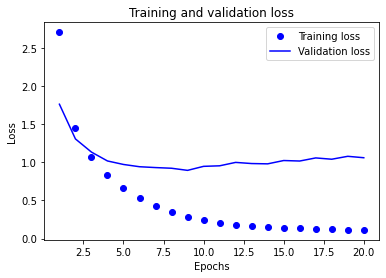

In [21]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

## 정확도곡선

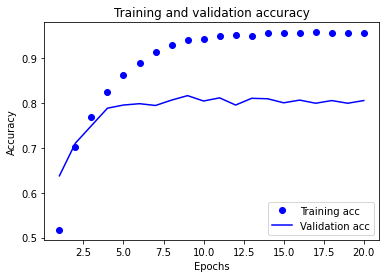

In [24]:
plt.clf()   # 초기화
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

## 과적합을 막기위해 epochs 를 조정하여 훈련

In [25]:
model = models.Sequential()
model.add(layers.Dense(64, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(46, activation='softmax'))

model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.fit(partial_x_train,
          partial_y_train,
          epochs=9,
          batch_size=512,
          validation_data=(x_val, y_val))
results = model.evaluate(x_test, one_hot_test_labels)

Epoch 1/9
16/16 [==============================] - 1s 28ms/step - loss: 2.7106 - accuracy: 0.4737 - val_loss: 1.7784 - val_accuracy: 0.6360
Epoch 2/9
16/16 [==============================] - 0s 16ms/step - loss: 1.4481 - accuracy: 0.7010 - val_loss: 1.2996 - val_accuracy: 0.7250
Epoch 3/9
16/16 [==============================] - 0s 18ms/step - loss: 1.0549 - accuracy: 0.7751 - val_loss: 1.1287 - val_accuracy: 0.7510
Epoch 4/9
16/16 [==============================] - 0s 16ms/step - loss: 0.8289 - accuracy: 0.8252 - val_loss: 1.0377 - val_accuracy: 0.7890
Epoch 5/9
16/16 [==============================] - 0s 19ms/step - loss: 0.6610 - accuracy: 0.8633 - val_loss: 0.9679 - val_accuracy: 0.8030
Epoch 6/9
16/16 [==============================] - 0s 19ms/step - loss: 0.5297 - accuracy: 0.8895 - val_loss: 0.9318 - val_accuracy: 0.8070
Epoch 7/9
16/16 [==============================] - 0s 18ms/step - loss: 0.4289 - accuracy: 0.9113 - val_loss: 0.9146 - val_accuracy: 0.8140
Epoch 8/9
16/16 [===

In [35]:
results

[0.9850311279296875, 0.7862867116928101]

## 46가지의 토픽 (label) 분포 확인

/usr/local/anaconda3/envs/ml/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:ylabel='count'>

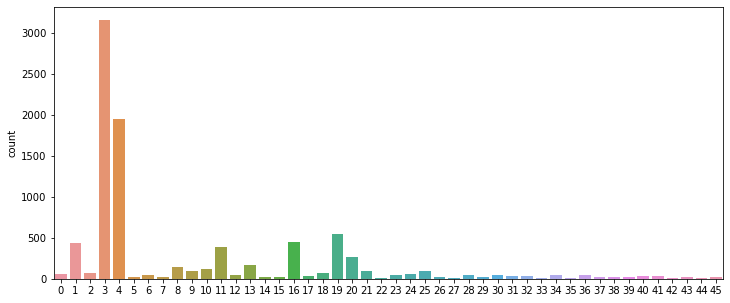

In [36]:
fig, axe = plt.subplots(ncols=1)
fig.set_size_inches(12,5)
sns.countplot(train_labels)

## 정리
- 46개의 토픽으로 분류하는 multiclass classification 이므로 softmax 활성화 함수를 사용.
- 46개의 multiclass 이므로 label 원핫 인코딩 진행.
- loss 함수를 categorical_crossentropy 를 사용.
- label 을 원 핫 인코딩을 하지 않고 정수형일 경우 loss 함수를 sparse_categorical_crossentropy 를 사용.
- label 변환을 위한 케라스 내장함수 from keras.utils.np_utils import to_categorical 을 사용가능.



## 추가내용
### batch_size = 30, epochs = 3 으로 조정

In [39]:
model = models.Sequential()
model.add(layers.Dense(64, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(46, activation='softmax'))

model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.fit(partial_x_train,
          partial_y_train,
          epochs=3,
          batch_size=30,
          validation_data=(x_val, y_val))
results = model.evaluate(x_test, one_hot_test_labels)

Epoch 1/3
267/267 [==============================] - 2s 4ms/step - loss: 1.4259 - accuracy: 0.6916 - val_loss: 1.0345 - val_accuracy: 0.7880
Epoch 2/3
267/267 [==============================] - 1s 4ms/step - loss: 0.7245 - accuracy: 0.8400 - val_loss: 0.8783 - val_accuracy: 0.8200
Epoch 3/3
71/71 [==============================] - 0s 1ms/step - loss: 0.9686 - accuracy: 0.7930


In [40]:
results

[0.9685558676719666, 0.792965292930603]